# Step 1: Setting up the environment

#### To create and activate a virtual environment, run on your terminal:

**Windows:**


```
python -m venv venv
```
```
venv\Scripts\Activate
```

**macOS/Linux:**

```
python3 -m venv venv
```

```
source venv/bin/activate
```

#### After the environment is activated, install the requirements:

```
pip install -r requirements.txt
```


# Step 2: Pre-processing the document

#### What you will need:
1. PDF Document (skin cancer detection paper in my case)
2. Embedding model (I am using Sentence-Bert)

As described in the Readme file, the aim of this tutorial is to build a RAG-assisted LLM that can retrieve information from research papers, helping students and researchers get a quicker understanding of the paper. This example will refer to a pdf titled *Real and simulated multispectral imaging of a palimpsest*. This paper is not yet publicly available since I am currently in the process of publishing, but feel free to use any paper you would like to retrieve information from. The same steps will apply to any paper / book. All you need to do is download it in pdf format and add your file path to the variable 'path'.

To pre-process the PDF document, we will use an embedding model. 

#### ⚠️ Now, what does “embedding” mean in AI?

In this tutorial, we are trying to get our AI model to understand a paper (complex text data). The problem is, our model can only understand numbers. That is where embeddings come in.

> An embedding is a way of representing complex data (like words or images) as a list of numbers — called a vector — in such a way that the relationships between items are preserved.


#### Let’s dive into that:

Think of each item (a word, an image, a sentence) as a point in space - a location on a map. The closer two points are, the more related their meanings are.

For example:

- The word “cat” will be close to “dog”.

- The word “car” will be far away from “banana”.

That’s because in real life, cats and dogs are similar (both animals, pets), while a car and a banana are not.

So embeddings help us map meaning into a mathematical space.

#### 🧐 What is an embedding model?

An embedding model is an AI model that has learned how to take something complex — like a sentence — and turn it into a vector (a list of numbers) that captures its meaning.

Different embedding models specialize in different kinds of data. The table below shows some examples of open-source embedding models for different use cases:


| Data Type      | Embedding model examples               | What do they capture?                            |
|----------------|----------------------------------------|--------------------------------------------------|
| Words          | Word2Vec, GloVe, FastText              | Word meanings, analogies, syntactic similarity   |
| Sentences/Text | Sentence-BERT (SBERT), Instructor, E5  | Semantic similarity between sentences/documents  |
| Images         | DINO, OpenCLIP                         | Visual concepts, cross-modal (image-text) meaning|
| Audio          | Wav2Vec 2.0, Whisper                   | Speech content, audio features                   |
| Code           | CodeBERT, GraphCodeBERT                | Code syntax and semantics                        |
  

In this tutorial we are looking to read PDF documents, therefore, we need a model that embeds data based on semantic similarity. I have chosen Sentence-BERT, but it is interchangable for any sentence / text embedding model. Once you have build your own RAG-assisted LLM, you can experiment with different models and decide what works best for you

Note that embedding models do not exactly embed words or sentences, they embed tokens.

#### ❓ What is a token?

A token is a smallest unit of input that a language model (like GPT or BERT) understands.

In most modern NLP systems, tokens are not exactly words — they can be:

- A whole word (hello)

- A subword (un, believ, able)

- A punctuation mark (!, .)

- Even just a few characters (Th, is)

Think of a token as a "chunk" of text — a building block the model processes one at a time.

> **Example**
> 
> Sentence: "This is amazing!" might be tokenized as:
> 
> ['This', ' is', ' amazing', '!']


.
> Note that, on average in English text, 1 token is equal to 4 characters.


#### Now that we know how the data pre_processing will work, let's get started. 








#### 2.1. Importing the relevant modules, getting the PDF we want to read, and extracting text from it:

In [34]:
# Import relevant modules
import fitz
import os
import requests
import re
from tqdm.auto import tqdm

# Get PDF path (change this variable to your pdf path)
#____________________________________________________________________
path = r"G:\My Drive\feines 2025\MS Imaging paper\to submit.pdf"
#____________________________________________________________________

# Check that the path exists
if os.path.exists(path):
    print(f"PDF file '{path}' exists.")
else:
    print(f"PDF file '{path}' does not exist")

# Open the PDF file
paper = fitz.open(path)
    
# Define a helper function to extract text from the pdf
def extract_text(paper: fitz.Document):
  """Applies formatting to the PDF textand stores the content in a list of dictionaries
  Inputs: 
      paper (fitz.Document): PDF document
  Outputs: 
      output (list[dict]): List of dictionaries containing the formatted extracted text from each PDF page 
      and the corresponding page number
  """

  # Define an empty list that will be filled with the extracted text
  output = []

  for page_number, page in enumerate(paper):
    paper_text = page.get_text()
    paper_text = re.sub(r'\s+', ' ', paper_text).strip() # removes any \n or white spaces
    output.append({"page_number": page_number,       
                   "text": paper_text
                   })
  return output

# Check that the helper function works as expected by printing the first sentence
output = extract_text(paper=paper)
display = output[0]["text"][:75]
print(" ")
print(f"'{display}...'")

PDF file 'G:\My Drive\feines 2025\MS Imaging paper\to submit.pdf' exists.
 
'For submission to Heritage Science Real and simulated multispectral imaging...'


#### 2.2. Segmenting the extracted text

First of all, we will use the Natural Language Processing (NLP) library **SpaCy** to divide our extracted text in sentences.

This is due to the fact that embedding models cannot process an infinite number of tokens, therefore we need to limit the number of tokens by chunking the text into groups of sentences.

For this tutorial I have split the text in chunks of 8 sentences, although this number is arbitrary. Feel free to experiment and decide what works best with your model. What is the criteria to keep in mind:
1. Smaller groups of text will be easier to inspect, making it easier to filter content
2. The text chunks need to fit into our embedding model's context window
3. Chunks too large will make the context that will be passed to the LLM too vague
4. Chunks too short might leave out information that is also relevant / be misleading
5. We want to find a chunk size so that the context passed to the LLM will be specific and focused

#### Please note that content after this line is still being finalised


In [35]:
# Import the English language model from spaCy
from spacy.lang.en import English

# Initialize the language processor
nlp_engine = English()

# Add sentence segmentation capability
# This NLP engine (SpaCy) breaks text into individual sentences
nlp_engine.add_pipe("sentencizer")

# Verify that sentence segmentation works correctly
sample_text = nlp_engine("SpaCy. is an NLP. library. that splits. text. into sentences. Let's. test. it.")
assert len(list(sample_text.sents)) == 9
print(f"This cell tests that the NLP engine (SpaCy) is detecting sentences as expected, \
and that the split_into_segments function splits the text in groups of \
{sentences_per_segment} sentences. \n")
print(list(sample_text.sents))

# Define how many sentences should be in each text segment
sentences_per_segment = 8

# Function to divide sentences into manageable segments
def split_into_segments(sentence_collection: list[str], 
                   segment_length: int = sentences_per_segment):
    """
    Divides a collection of sentences into segments of specified length
    
    Args:
        sentence_collection: List of sentences to divide
        segment_length: Maximum number of sentences per segment
        
    Returns:
        List of sentence segments
    """
    segments = []
    for i in range(0, len(sentence_collection), segment_length):
        segments.append(sentence_collection[i:i + segment_length])
    return segments

# Test segmentation function
test_sentences = [sent.text for sent in sample_text.sents]
split_into_segments(test_sentences)

This cell tests that the NLP engine (SpaCy) is detecting sentences as expected, and that the split_into_segments function splits the text in groups of 8 sentences. 

[SpaCy., is an NLP., library., that splits., text., into sentences., Let's., test., it.]


[['SpaCy.',
  'is an NLP.',
  'library.',
  'that splits.',
  'text.',
  'into sentences.',
  "Let's.",
  'test.'],
 ['it.']]

In [36]:
# Process each page in the PDF document
for item in tqdm(output):
    # Identify sentences in the document text
    pdf_processed = nlp_engine(item["text"])
    
    # Store sentences as strings
    item["sentences"] = [str(sent) for sent in pdf_processed.sents]
    
    # Create sentence segments and count them
    item["sentence_segments"] = split_into_segments(
        sentence_collection=item["sentences"],
        segment_length=sentences_per_segment
    )
    
    # Record metadata
    item["segment_count"] = len(item["sentence_segments"])
    item["sentence_count"] = len(item["sentences"])

100%|█████████████████████████| 14/14 [00:00<00:00, 189.98it/s]


Once the document has been divided in groups of sentences (segments or chunks), we will display a sample of one page in the PDF, to ensure this task was performed correctly. Additionally, we will print statistics on the average number of sentences and sentence segments per page.

In [46]:
import random

# Print a random sample from the output
print("\nRandom Sample (shortened for display):")
sample_item = random.sample(output, k=1)[0]  # Get one random item

# Create a copy of the sample to modify for display
display_sample = sample_item.copy()

# Truncate the text to first 10 characters
if "text" in display_sample:
    display_sample["text"] = display_sample["text"][:10] + "..." if len(display_sample["text"]) > 10 else display_sample["text"]

# Truncate each sentence to first 10 characters
if "sentences" in display_sample:
    display_sample["sentences"] = [s[:10] + "..." if len(s) > 10 else s for s in display_sample["sentences"]]

# Truncate each sentence segment to first 10 characters
if "sentence_segments" in display_sample:
    # For each segment in the list of segments
    display_sample["sentence_segments"] = [
        # For each sentence in the segment
        [s[:10] + "..." if len(s) > 10 else s for s in segment]
        for segment in display_sample["sentence_segments"]]

# Print the modified sample
import pprint
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(display_sample)


Random Sample (shortened for display):
{ 'page_number': 6,
  'segment_count': 2,
  'sentence_count': 10,
  'sentence_segments': [ [ 'Figure 3: ...',
                           'As in Fig ...',
                           'b)-(e) are...',
                           'There is a...',
                           'At interme...',
                           'There is l...',
                           'This diffe...',
                           'There is l...'],
                         ['The contra...', 'This is pr...']],
  'sentences': [ 'Figure 3: ...',
                 'As in Fig ...',
                 'b)-(e) are...',
                 'There is a...',
                 'At interme...',
                 'There is l...',
                 'This diffe...',
                 'There is l...',
                 'The contra...',
                 'This is pr...'],
  'text': 'Figure 3: ...'}


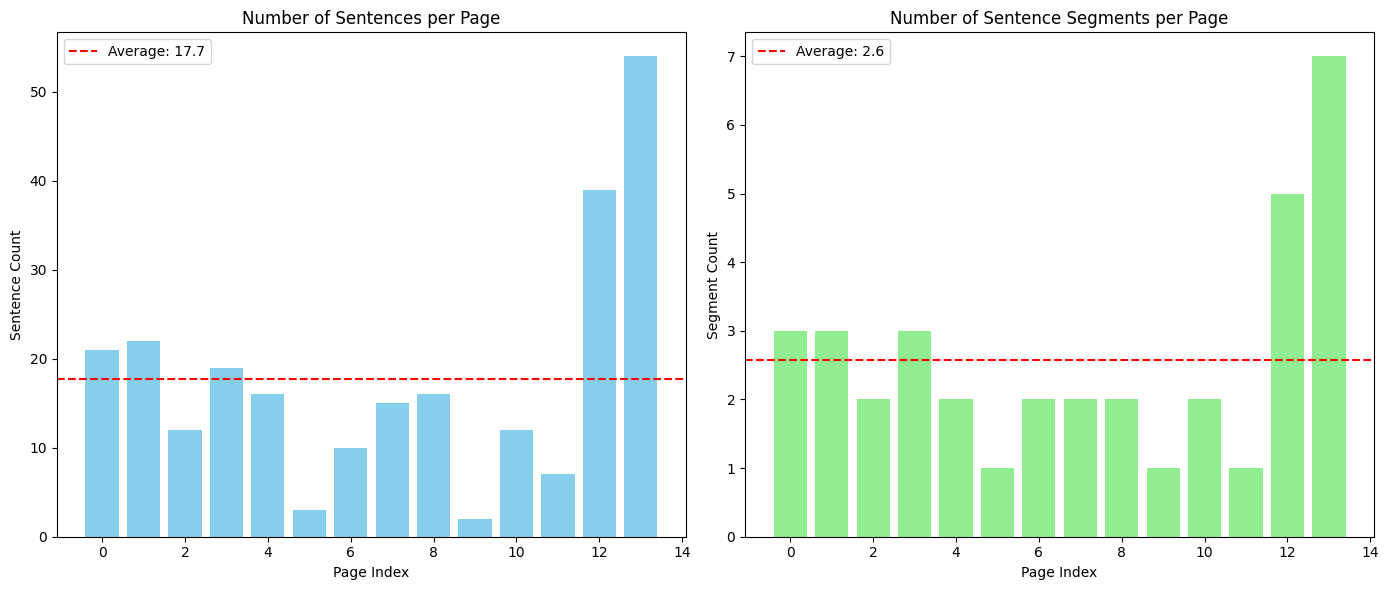

Document statistics:
Total pages: 14
Total sentences: 248
Average sentences per page: 17.7
Average segments per page: 2.6
 


In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the data for plotting
sentence_counts = [item["sentence_count"] for item in output]
segment_counts = [item["segment_count"] for item in output]

# Calculate averages
avg_sentence_count = np.mean(sentence_counts)
avg_segment_count = np.mean(segment_counts)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# First chart: Sentences per page
ax1.bar(range(len(sentence_counts)), sentence_counts, color='skyblue')
ax1.axhline(y=avg_sentence_count, color='red', linestyle='--', 
            label=f'Average: {avg_sentence_count:.1f}')
ax1.set_title('Number of Sentences per Page')
ax1.set_xlabel('Page Index')
ax1.set_ylabel('Sentence Count')
ax1.legend()

# Second chart: Sentence segments per page
ax2.bar(range(len(segment_counts)), segment_counts, color='lightgreen')
ax2.axhline(y=avg_segment_count, color='red', linestyle='--', 
            label=f'Average: {avg_segment_count:.1f}')
ax2.set_title('Number of Sentence Segments per Page')
ax2.set_xlabel('Page Index')
ax2.set_ylabel('Segment Count')
ax2.legend()

# Adjust layout and display
plt.tight_layout()
plt.savefig('document_analysis.png', dpi=300)
plt.show()

# Print summary statistics
print(f"Document statistics:")
print(f"Total pages: {len(output)}")
print(f"Total sentences: {sum(sentence_counts)}")
print(f"Average sentences per page: {avg_sentence_count:.1f}")
print(f"Average segments per page: {avg_segment_count:.1f}")
print(" ")




The final step in section _'2.2. Segmenting the extracted text'_ is to join all sentences within 1 segmented, converting the segment back into a paragraph. Each joined paragraph will be treated as a document entry.

In [49]:
# Define text formatting function
def format_text(text):
    """Apply consistent formatting to scientific text for improved readability."""
    # Fix spacing after common punctuation marks
    for punct in ['.', ',', ';', ':', '?', '!']:
        text = re.sub(f'\\{punct}([^\\s])', f'{punct} \\1', text)
    
    # Remove duplicate spaces
    text = re.sub(r' {2,}', ' ', text)

    # Apply strip() function and remove '\n'
    text = text.replace("\n", " ").strip()
    
    # Standardize citation formatting (e.g., "[1]text" → "[1] text")
    text = re.sub(r'(\[\d+\])([A-Za-z])', r'\1 \2', text)
    
    return text
    
# Convert each segment into its own document entry
final_segments = []
for item in tqdm(output):
  for segment in item["sentence_segments"]:
    # Create a new dictionary for this segment
    segment_entry = {}
    
    # Preserve the source page information
    segment_entry["page_number"] = item["page_number"]
    
    # Combine sentences into a single coherent paragraph
    combined_text = "".join(segment)

    # Clean formatting using helper function
    cleaned_text = format_text(combined_text)
    
    # Store the processed text
    segment_entry["content"] = cleaned_text
    
    # Calculate approximate token count (rough estimation)
    segment_entry["estimated_tokens"] = len(cleaned_text) / 4
    
    # Add to our collection
    final_segments.append(segment_entry)

# Display total number of segments created
print(f"Total segments created: {len(final_segments)}")

100%|████████████████████████| 14/14 [00:00<00:00, 2112.32it/s]

Total segments created: 36


In [65]:
import random
print(f"The variable 'final_segments' has a length of: {len(final_segments)}")

display_segment = random. randint(0, len(final_segments))
display = final_segments[display_segment]["content"][:30]
print(" ")
print(f"'{display}...'")

The variable 'final_segments' has a length of: 36
 
'Figures b and d show the first...'



# CONTINUE FROM HERE

#### 2.3. Embedding each text chunk
The next step is to **embed** each segment of sentences into its own **numerical representation**.

For this I will be using the 


# OPTION 1: allenai/specter2_base

In [10]:
# OPTION 1
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from time import perf_counter
from tqdm import tqdm

def embed_chunks(final_chunks):
    """
    Generate embeddings for all sentence chunks using SPECTER2 model.
    
    Args:
        final_chunks: List of dictionaries containing sentence chunks
        
    Returns:
        Updated list with embeddings added to each dictionary
    """
    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained('allenai/specter2_base')
    model = AutoModel.from_pretrained('allenai/specter2_base')
    
    # Set device (use GPU if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Process batches to improve efficiency
    batch_size = 16
    
    for i in tqdm(range(0, len(final_chunks), batch_size), desc="Generating embeddings"):
        # Get the current batch
        batch = final_chunks[i:i+batch_size]
        
        # Extract texts from the batch
        texts = [item["sentence_chunk"] for item in batch]
        
        # Tokenize the batch
        inputs = tokenizer(texts, padding=True, truncation=True, 
                          max_length=512, return_tensors="pt")
        
        # Move inputs to the appropriate device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Forward pass to get embeddings
        with torch.no_grad():
            outputs = model(**inputs)
            # Take the CLS token (first token) as the embedding
            embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        
        # Assign embeddings to the items in the batch
        for j, item in enumerate(batch):
            final_chunks[i+j]["embedding"] = embeddings[j]
    
    return final_chunks


def search_similar_chunks(final_chunks, query_text, top_k=5):
    """
    Search for chunks similar to a query using dot product similarity.
    
    Args:
        final_chunks: List of dictionaries containing text chunks and their embeddings
        query_text: The query text to search for
        top_k: Number of top results to return
        
    Returns:
        Tuple of (indices, scores, results) for the top similar chunks
    """
    # Load model and tokenizer (same as used for embedding chunks)
    tokenizer = AutoTokenizer.from_pretrained('allenai/specter2_base')
    model = AutoModel.from_pretrained('allenai/specter2_base')
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    print(f"Query: {query_text}")
    
    # 1. Embed the query using the same model
    inputs = tokenizer(query_text, padding=True, truncation=True, 
                      max_length=512, return_tensors="pt").to(device)
    
    # Get query embedding
    start_time = perf_counter()
    with torch.no_grad():
        outputs = model(**inputs)
        query_embedding = outputs.last_hidden_state[:, 0, :]  # CLS token
    
    # 2. Convert all chunk embeddings to a tensor for batch processing
    # First, extract all embeddings from final_chunks
    all_embeddings = np.array([chunk["embedding"] for chunk in final_chunks])
    all_embeddings_tensor = torch.tensor(all_embeddings).to(device)
    
    # 3. Compute dot product similarity
    # Normalize embeddings for better results (optional if model outputs are already normalized)
    query_embedding = query_embedding / query_embedding.norm(dim=1, keepdim=True)
    all_embeddings_tensor = all_embeddings_tensor / all_embeddings_tensor.norm(dim=1, keepdim=True)
    
    # Compute similarity scores
    dot_scores = torch.matmul(query_embedding, all_embeddings_tensor.T)[0]
    
    # 4. Get top-k results
    top_k_scores, top_k_indices = torch.topk(dot_scores, min(top_k, len(final_chunks)))
    
    end_time = perf_counter()
    print(f"Search completed in {end_time - start_time:.4f} seconds")
    
    # Convert to Python lists
    top_k_indices = top_k_indices.cpu().numpy()
    top_k_scores = top_k_scores.cpu().numpy()
    
    # Get the actual chunks for the top results
    top_results = [final_chunks[idx] for idx in top_k_indices]
    
    # Print results
    print("\nTop results:")
    for i, (score, result) in enumerate(zip(top_k_scores, top_results)):
        print(f"{i+1}. Score: {score:.4f}")
        print(f"   Page: {result['page_number']}")
        print(f"   Text: {result['sentence_chunk']}")
        print()
    
    return top_k_indices, top_k_scores, top_results

    
# Example usage
if __name__ == "__main__":
    # Assuming final_chunks is your processed data
    final_embedded_chunks = embed_chunks(final_chunks)
    print(f"Generated embeddings for {len(final_chunks)} chunks")
    
    # Optional: Check the embedding dimension
    if final_chunks:
        print(f"Embedding dimension: {final_embedded_chunks[0]['embedding'].shape}")
        
    query = "EEG reading while blinking"
    indices, scores, results = search_similar_chunks(final_chunks, query)

Generating embeddings: 100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:12<00:00,  6.10s/it]


Generated embeddings for 24 chunks
Embedding dimension: (768,)
Query: EEG reading while blinking
Search completed in 0.1275 seconds

Top results:
1. Score: 0.8653
   Page: 13
   Text: 9. Stuart MB, McGonigle AJS, Davies M, Hobbs MJ, Boone NA, Stanger LR, et al. Low-Cost Hyperspectral Imaging with A Smartphone. Journal of Imaging.2021;7.10. Daukantas P. Hyperspectral Imaging Meets Biomedicine. Opt Photon News.2020;31:32–9.11. He Q, Wang R. Hyperspectral imaging enabled by an unmodified smartphone for analyzing skin morphological features and monitoring hemodynamics. Biomed Opt Express.2020;11:895–910.12. He Q, Li W, Shi Y, Yu Y, Geng W, Sun Z, et al.

2. Score: 0.8605
   Page: 13
   Text: SpeCamX: mobile app that turns unmodified smartphones into multispectral imagers. Biomed Opt Express.2023;14:4929–46.13. Valleriani M, Ottone A, editors. Publishing Sacrobosco’s De sphaera in Early Modern Europe: Modes of Material and Scientific Exchange [Internet]. Cham: Springer International Publish

# OPTION 2: BERT Mpbnet

In [18]:
import torch
import numpy as np
from sentence_transformers import SentenceTransformer
from time import perf_counter
from tqdm import tqdm

def embed_chunks(final_chunks):
    """
    Generate embeddings for all sentence chunks using MPNet model.
    
    Args:
        final_chunks: List of dictionaries containing sentence chunks
        
    Returns:
        Updated list with embeddings added to each dictionary
    """
    # Load model - MPNet is designed specifically for embeddings
    model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
    
    # Set device (use GPU if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Process batches to improve efficiency
    batch_size = 16
    
    for i in tqdm(range(0, len(final_chunks), batch_size), desc="Generating embeddings"):
        # Get the current batch
        batch = final_chunks[i:i+batch_size]
        
        # Extract texts from the batch
        texts = [item["sentence_chunk"] for item in batch]
        
        # Generate embeddings directly (simpler than with Transformers)
        # The encode method handles tokenization, model inference, and extraction
        embeddings = model.encode(texts, convert_to_tensor=True)
        
        # Convert to numpy and store
        embeddings_np = embeddings.cpu().numpy()
        
        # Assign embeddings to the items in the batch
        for j, item in enumerate(batch):
            final_chunks[i+j]["embedding"] = embeddings_np[j]
    
    return final_chunks


def search_similar_chunks(final_chunks, query_text, top_k=5):
    """
    Search for chunks similar to a query using cosine similarity.
    
    Args:
        final_chunks: List of dictionaries containing text chunks and their embeddings
        query_text: The query text to search for
        top_k: Number of top results to return
        
    Returns:
        Tuple of (indices, scores, results) for the top similar chunks
    """
    # Load model (same as used for embedding chunks)
    model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    print(f"Query: {query_text}")
    
    # 1. Embed the query using the same model
    start_time = perf_counter()
    query_embedding = model.encode(query_text, convert_to_tensor=True).to(device)
    
    # 2. Convert all chunk embeddings to a tensor for batch processing
    all_embeddings = np.array([chunk["embedding"] for chunk in final_chunks])
    all_embeddings_tensor = torch.tensor(all_embeddings).to(device)
    
    # 3. Compute cosine similarity
    # SentenceTransformer models already normalize outputs, but let's ensure
    # Normalize embeddings if needed
    all_embeddings_tensor = all_embeddings_tensor / all_embeddings_tensor.norm(dim=1, keepdim=True)
    
    # Compute similarity scores (dot product of normalized vectors = cosine similarity)
    similarity_scores = torch.matmul(query_embedding.unsqueeze(0), all_embeddings_tensor.T)[0]
    
    # 4. Get top-k results
    top_k_scores, top_k_indices = torch.topk(similarity_scores, min(top_k, len(final_chunks)))
    
    end_time = perf_counter()
    print(f"Search completed in {end_time - start_time:.4f} seconds")
    
    # Convert to Python lists
    top_k_indices = top_k_indices.cpu().numpy()
    top_k_scores = top_k_scores.cpu().numpy()
    
    # Get the actual chunks for the top results
    top_results = [final_chunks[idx] for idx in top_k_indices]
    
    # Print results
    print("\nTop results:")
    for i, (score, result) in enumerate(zip(top_k_scores, top_results)):
        print(f"{i+1}. Score: {score:.4f}")
        print(f"   Page: {result['page_number']}")
        print(f"   Text: {result['sentence_chunk']}")  # Show just a preview
        print()
    
    return top_k_indices, top_k_scores, top_results


# Enhanced version with statistical analysis
def analyze_similarity_distribution(final_chunks, query_text):
    """
    Analyze the distribution of similarity scores for a query.
    
    Args:
        final_chunks: List of dictionaries containing text chunks and their embeddings
        query_text: The query text to search for
        
    Returns:
        Tuple of (scores, threshold)
    """
    # Load model
    model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    print(f"Analyzing similarity distribution for query: {query_text}")
    
    # Embed the query
    query_embedding = model.encode(query_text, convert_to_tensor=True).to(device)
    
    # Get all embeddings
    all_embeddings = np.array([chunk["embedding"] for chunk in final_chunks])
    all_embeddings_tensor = torch.tensor(all_embeddings).to(device)
    
    # Ensure normalized vectors
    all_embeddings_tensor = all_embeddings_tensor / all_embeddings_tensor.norm(dim=1, keepdim=True)
    
    # Compute similarity scores
    similarity_scores = torch.matmul(query_embedding.unsqueeze(0), all_embeddings_tensor.T)[0].cpu().numpy()
    
    # Analyze distribution
    mean_score = np.mean(similarity_scores)
    std_score = np.std(similarity_scores)
    min_score = np.min(similarity_scores)
    max_score = np.max(similarity_scores)
    
    # Calculate a reasonable threshold (mean + 1.5*std is often useful)
    threshold = mean_score + 1.5 * std_score
    
    print(f"Score Statistics:")
    print(f"  Mean: {mean_score:.4f}")
    print(f"  Std Dev: {std_score:.4f}")
    print(f"  Min: {min_score:.4f}")
    print(f"  Max: {max_score:.4f}")
    print(f"  Suggested Threshold: {threshold:.4f}")
    print(f"  Documents above threshold: {np.sum(similarity_scores > threshold)}/{len(similarity_scores)}")
    
    return similarity_scores, threshold


# Example usage
if __name__ == "__main__":
    # Assuming final_chunks is your processed data
    final_embedded_chunks = embed_chunks(final_chunks)
    print(f"Generated embeddings for {len(final_chunks)} chunks")
    
    # Optional: Check the embedding dimension
    if final_chunks:
        print(f"Embedding dimension: {final_embedded_chunks[0]['embedding'].shape}")
    
    # First analyze distribution
    query = "Adam Gibson"
    scores, threshold = analyze_similarity_distribution(final_embedded_chunks, query)
    
    # Then search with that threshold
    indices, scores, results = search_similar_chunks(final_embedded_chunks, query)

Generating embeddings: 100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.05s/it]


Generated embeddings for 24 chunks
Embedding dimension: (768,)
Analyzing similarity distribution for query: Adam Gibson
Score Statistics:
  Mean: -0.0059
  Std Dev: 0.0349
  Min: -0.0650
  Max: 0.0612
  Suggested Threshold: 0.0464
  Documents above threshold: 2/24
Query: Adam Gibson
Search completed in 0.1006 seconds

Top results:
1. Score: 0.0612
   Page: 11
   Text: Figure 6: Images of the Archimedes Palimpsest. (a-d) are four original images taken from archimedespalimpsest.net, licenced under CC 3.0 (with Unported Access Rights). (e-h) are simulated MSI images, taken at the closest available wavelengths 6. Conclusion We have successfully used standard MSI imaging with minimal image processing to reveal two different works making up the undertext of a palimpsest. This new information will be added to the catalogue records and provide deeper context when this book is used in teaching. This work shows that simulated multispectral images can be generated from standard digitised images t

In [23]:
import torch
import numpy as np
from sentence_transformers import SentenceTransformer
from time import perf_counter
from tqdm import tqdm

def embed_chunks(final_chunks):
    """
    Generate embeddings for all sentence chunks using MiniLM model.
    
    Args:
        final_chunks: List of dictionaries containing sentence chunks
        
    Returns:
        Updated list with embeddings added to each dictionary
    """
    # Load model - MiniLM is faster and lighter than MPNet
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    
    # Set device (use GPU if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Process batches to improve efficiency
    # We can use a larger batch size with the smaller model
    batch_size = 32
    
    for i in tqdm(range(0, len(final_chunks), batch_size), desc="Generating embeddings"):
        # Get the current batch
        batch = final_chunks[i:i+batch_size]
        
        # Extract texts from the batch
        texts = [item["sentence_chunk"] for item in batch]
        
        # Generate embeddings directly (simpler than with Transformers)
        # The encode method handles tokenization, model inference, and extraction
        embeddings = model.encode(texts, convert_to_tensor=True)
        
        # Convert to numpy and store
        embeddings_np = embeddings.cpu().numpy()
        
        # Assign embeddings to the items in the batch
        for j, item in enumerate(batch):
            final_chunks[i+j]["embedding"] = embeddings_np[j]
    
    return final_chunks


def search_similar_chunks(final_chunks, query_text, top_k=5):
    """
    Search for chunks similar to a query using cosine similarity.
    
    Args:
        final_chunks: List of dictionaries containing text chunks and their embeddings
        query_text: The query text to search for
        top_k: Number of top results to return
        
    Returns:
        Tuple of (indices, scores, results) for the top similar chunks
    """
    # Load model (same as used for embedding chunks)
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    print(f"Query: {query_text}")
    
    # 1. Embed the query using the same model
    start_time = perf_counter()
    query_embedding = model.encode(query_text, convert_to_tensor=True).to(device)
    
    # 2. Convert all chunk embeddings to a tensor for batch processing
    all_embeddings = np.array([chunk["embedding"] for chunk in final_chunks])
    all_embeddings_tensor = torch.tensor(all_embeddings).to(device)
    
    # 3. Compute cosine similarity
    # SentenceTransformer models already normalize outputs, but let's ensure
    # Normalize embeddings if needed
    all_embeddings_tensor = all_embeddings_tensor / all_embeddings_tensor.norm(dim=1, keepdim=True)
    query_embedding = query_embedding / query_embedding.norm()
    
    # Compute similarity scores (dot product of normalized vectors = cosine similarity)
    similarity_scores = torch.matmul(query_embedding.unsqueeze(0), all_embeddings_tensor.T)[0]
    
    # 4. Get top-k results
    top_k_scores, top_k_indices = torch.topk(similarity_scores, min(top_k, len(final_chunks)))
    
    end_time = perf_counter()
    print(f"Search completed in {end_time - start_time:.4f} seconds")
    
    # Convert to Python lists
    top_k_indices = top_k_indices.cpu().numpy()
    top_k_scores = top_k_scores.cpu().numpy()
    
    # Get the actual chunks for the top results
    top_results = [final_chunks[idx] for idx in top_k_indices]
    
    # Print results
    print("\nTop results:")
    for i, (score, result) in enumerate(zip(top_k_scores, top_results)):
        print(f"{i+1}. Score: {score:.4f}")
        print(f"   Page: {result['page_number']}")
        print(f"   Text: {result['sentence_chunk']}")  # Show just a preview
        print()
    
    return top_k_indices, top_k_scores, top_results


# Enhanced version with statistical analysis
def analyze_similarity_distribution(final_chunks, query_text):
    """
    Analyze the distribution of similarity scores for a query.
    
    Args:
        final_chunks: List of dictionaries containing text chunks and their embeddings
        query_text: The query text to search for
        
    Returns:
        Tuple of (scores, threshold)
    """
    # Load model
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    print(f"Analyzing similarity distribution for query: {query_text}")
    
    # Embed the query
    query_embedding = model.encode(query_text, convert_to_tensor=True).to(device)
    
    # Get all embeddings
    all_embeddings = np.array([chunk["embedding"] for chunk in final_chunks])
    all_embeddings_tensor = torch.tensor(all_embeddings).to(device)
    
    # Ensure normalized vectors
    all_embeddings_tensor = all_embeddings_tensor / all_embeddings_tensor.norm(dim=1, keepdim=True)
    query_embedding = query_embedding / query_embedding.norm()
    
    # Compute similarity scores
    similarity_scores = torch.matmul(query_embedding.unsqueeze(0), all_embeddings_tensor.T)[0].cpu().numpy()
    
    # Analyze distribution
    mean_score = np.mean(similarity_scores)
    std_score = np.std(similarity_scores)
    min_score = np.min(similarity_scores)
    max_score = np.max(similarity_scores)
    
    # Calculate a reasonable threshold (mean + 1.5*std is often useful)
    threshold = mean_score + 1.5 * std_score
    
    print(f"Score Statistics:")
    print(f"  Mean: {mean_score:.4f}")
    print(f"  Std Dev: {std_score:.4f}")
    print(f"  Min: {min_score:.4f}")
    print(f"  Max: {max_score:.4f}")
    print(f"  Suggested Threshold: {threshold:.4f}")
    print(f"  Documents above threshold: {np.sum(similarity_scores > threshold)}/{len(similarity_scores)}")
    
    return similarity_scores, threshold


# Example usage
if __name__ == "__main__":
    # Assuming final_chunks is your processed data
    final_embedded_chunks = embed_chunks(final_chunks)
    print(f"Generated embeddings for {len(final_chunks)} chunks")
    
    # Optional: Check the embedding dimension
    if final_chunks:
        print(f"Embedding dimension: {final_embedded_chunks[0]['embedding'].shape}")
    
    # First analyze distribution
    query = " UCL Multispectral Imaging system"
    scores, threshold = analyze_similarity_distribution(final_embedded_chunks, query)
    
    # Then search with that threshold
    indices, scores, results = search_similar_chunks(final_embedded_chunks, query)


G:\My Drive\feines 2025\Github\tutorial_RAG-assisted-LLM\venv_llm\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\marti\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package i

Generated embeddings for 24 chunks
Embedding dimension: (384,)
Analyzing similarity distribution for query: Canon EOS 6D camera with a 50 mm lens
Score Statistics:
  Mean: 0.0653
  Std Dev: 0.0698
  Min: -0.0660
  Max: 0.2599
  Suggested Threshold: 0.1700
  Documents above threshold: 1/24
Query: Canon EOS 6D camera with a 50 mm lens
Search completed in 0.0247 seconds

Top results:
1. Score: 0.2599
   Page: 3
   Text: The original digitised images were downloaded and inspected. Multispectral images were acquired of 13 sheets using the UCL Multispectral Imaging System. Simulated MSI images were generated using the process described in section 2.4, and using a W matrix that mapped between the Canon EOS 6D camera used for digitisation and the PhaseOne system used for MSI.2.5 Post processing

2. Score: 0.1665
   Page: 11
   Text: Figure 6: Images of the Archimedes Palimpsest. (a-d) are four original images taken from archimedespalimpsest.net, licenced under CC 3.0 (with Unported Access Righ

#### 2.4. Similarity Search

# EXPLAIN
# CHANGE EMBEDDING MODEL E.G. MPBNET
Note:
We want to: search for a query (e.g. "macronutrient functions") and get relevant info from textbook.

Steps to do this:
1. Define query string
2. Turn query string into embedding
3. Perform dot product or cosine similarity function between the text embeddings and the query embedding
4. Sort the results form 3 in descending order


Note: to use dot product for comparison ensure both vector sizes are of the same shape and tensors/vectors are in the same data type.

In [ ]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from time import perf_counter
from tqdm import tqdm

def search_similar_chunks(final_chunks, query_text, top_k=5):
    """
    Search for chunks similar to a query using dot product similarity.
    
    Args:
        final_chunks: List of dictionaries containing text chunks and their embeddings
        query_text: The query text to search for
        top_k: Number of top results to return
        
    Returns:
        Tuple of (indices, scores, results) for the top similar chunks
    """
    # Load model and tokenizer (same as used for embedding chunks)
    tokenizer = AutoTokenizer.from_pretrained('allenai/specter2_base')
    model = AutoModel.from_pretrained('allenai/specter2_base')
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    print(f"Query: {query_text}")
    
    # 1. Embed the query using the same model
    inputs = tokenizer(query_text, padding=True, truncation=True, 
                      max_length=512, return_tensors="pt").to(device)
    
    # Get query embedding
    start_time = perf_counter()
    with torch.no_grad():
        outputs = model(**inputs)
        query_embedding = outputs.last_hidden_state[:, 0, :]  # CLS token
    
    # 2. Convert all chunk embeddings to a tensor for batch processing
    # First, extract all embeddings from final_chunks
    all_embeddings = np.array([chunk["embedding"] for chunk in final_chunks])
    all_embeddings_tensor = torch.tensor(all_embeddings).to(device)
    
    # 3. Compute dot product similarity
    # Normalize embeddings for better results (optional if model outputs are already normalized)
    query_embedding = query_embedding / query_embedding.norm(dim=1, keepdim=True)
    all_embeddings_tensor = all_embeddings_tensor / all_embeddings_tensor.norm(dim=1, keepdim=True)
    
    # Compute similarity scores
    dot_scores = torch.matmul(query_embedding, all_embeddings_tensor.T)[0]
    
    # 4. Get top-k results
    top_k_scores, top_k_indices = torch.topk(dot_scores, min(top_k, len(final_chunks)))
    
    end_time = perf_counter()
    print(f"Search completed in {end_time - start_time:.4f} seconds")
    
    # Convert to Python lists
    top_k_indices = top_k_indices.cpu().numpy()
    top_k_scores = top_k_scores.cpu().numpy()
    
    # Get the actual chunks for the top results
    top_results = [final_chunks[idx] for idx in top_k_indices]
    
    # Print results
    print("\nTop results:")
    for i, (score, result) in enumerate(zip(top_k_scores, top_results)):
        print(f"{i+1}. Score: {score:.4f}")
        print(f"   Page: {result['page_number']}")
        print(f"   Text: {result['sentence_chunk']}")
        print()
    
    return top_k_indices, top_k_scores, top_results

# Example usage
if __name__ == "__main__":
    query = "Martina Sabate"
    indices, scores, results = search_similar_chunks(final_chunks, query)

In [ ]:
# OPTION 2 (IMPROVED BY CLAUDE)

import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from time import perf_counter
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def analyze_similarity_distribution(final_chunks, query_text):
    """
    Analyze the distribution of similarity scores for a query.
    
    Args:
        final_chunks: List of dictionaries containing text chunks and their embeddings
        query_text: The query text to search for
        
    Returns:
        Tuple of (scores, normalized_scores, threshold)
    """
    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained('allenai/specter2_base')
    model = AutoModel.from_pretrained('allenai/specter2_base')
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    print(f"Analyzing similarity distribution for query: {query_text}")
    
    # Embed the query
    inputs = tokenizer(query_text, padding=True, truncation=True, 
                      max_length=512, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        query_embedding = outputs.last_hidden_state[:, 0, :]
    
    # Normalize query embedding
    query_embedding = query_embedding / query_embedding.norm(dim=1, keepdim=True)
    
    # Get all embeddings
    all_embeddings = np.array([chunk["embedding"] for chunk in final_chunks])
    all_embeddings_tensor = torch.tensor(all_embeddings).to(device)
    all_embeddings_tensor = all_embeddings_tensor / all_embeddings_tensor.norm(dim=1, keepdim=True)
    
    # Compute similarity scores
    dot_scores = torch.matmul(query_embedding, all_embeddings_tensor.T)[0].cpu().numpy()
    
    # Analyze distribution
    mean_score = np.mean(dot_scores)
    std_score = np.std(dot_scores)
    min_score = np.min(dot_scores)
    max_score = np.max(dot_scores)
    
    # Calculate Z-scores for outlier detection
    z_scores = (dot_scores - mean_score) / std_score
    
    # Identify potential threshold
    # A common approach is mean + 2*std for outlier detection
    threshold = mean_score + 2 * std_score
    
    # Use MinMaxScaler to rescale scores to [0,1] range
    # This helps interpret relative relevance
    scaler = MinMaxScaler()
    normalized_scores = scaler.fit_transform(dot_scores.reshape(-1, 1)).flatten()
    
    # Plot distribution
    plt.figure(figsize=(10, 6))
    plt.hist(dot_scores, bins=30, alpha=0.7)
    plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.4f}')
    plt.axvline(mean_score, color='g', linestyle='-', label=f'Mean: {mean_score:.4f}')
    plt.title('Distribution of Similarity Scores')
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    print(f"Score Statistics:")
    print(f"  Mean: {mean_score:.4f}")
    print(f"  Std Dev: {std_score:.4f}")
    print(f"  Min: {min_score:.4f}")
    print(f"  Max: {max_score:.4f}")
    print(f"  Suggested Threshold: {threshold:.4f}")
    print(f"  Documents above threshold: {np.sum(dot_scores > threshold)}/{len(dot_scores)}")
    
    # Return scores for further analysis
    return dot_scores, normalized_scores, threshold


def search_similar_chunks(final_chunks, query_text, top_k=5, threshold=None, use_relative_scoring=True):
    """
    Search for chunks similar to a query using improved scoring mechanisms.
    
    Args:
        final_chunks: List of dictionaries containing text chunks and their embeddings
        query_text: The query text to search for
        top_k: Number of top results to return
        threshold: Optional cutoff value for scores
        use_relative_scoring: Whether to use relative (normalized) scoring
        
    Returns:
        Tuple of (indices, scores, results) for the top similar chunks
    """
    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained('allenai/specter2_base')
    model = AutoModel.from_pretrained('allenai/specter2_base')
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    print(f"Query: {query_text}")
    
    # 1. Embed the query
    start_time = perf_counter()
    inputs = tokenizer(query_text, padding=True, truncation=True, 
                      max_length=512, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        query_embedding = outputs.last_hidden_state[:, 0, :]
    
    # 2. Normalize query embedding
    query_embedding = query_embedding / query_embedding.norm(dim=1, keepdim=True)
    
    # 3. Get all chunk embeddings
    all_embeddings = np.array([chunk["embedding"] for chunk in final_chunks])
    all_embeddings_tensor = torch.tensor(all_embeddings).to(device)
    all_embeddings_tensor = all_embeddings_tensor / all_embeddings_tensor.norm(dim=1, keepdim=True)
    
    # 4. Compute similarity scores
    dot_scores = torch.matmul(query_embedding, all_embeddings_tensor.T)[0].cpu().numpy()
    
    # 5. Compute relative scores
    if use_relative_scoring:
        mean_score = np.mean(dot_scores)
        std_score = np.std(dot_scores)
        # Convert to Z-scores
        relative_scores = (dot_scores - mean_score) / std_score
        # Also compute min-max scaled scores for easier interpretation
        scaler = MinMaxScaler()
        scaled_scores = scaler.fit_transform(dot_scores.reshape(-1, 1)).flatten()
    
    # 6. Apply threshold if specified
    if threshold is not None:
        valid_indices = np.where(dot_scores >= threshold)[0]
        if len(valid_indices) == 0:
            print("No results above threshold")
            return [], [], []
        
        # Filter based on threshold
        filtered_scores = dot_scores[valid_indices]
        top_k = min(top_k, len(filtered_scores))
        
        # Get top-k among valid indices
        top_indices = np.argsort(-filtered_scores)[:top_k]
        top_indices = valid_indices[top_indices]
        top_scores = dot_scores[top_indices]
    else:
        # Get top-k without threshold
        top_indices = np.argsort(-dot_scores)[:top_k]
        top_scores = dot_scores[top_indices]
    
    # Get the actual chunks
    top_results = [final_chunks[idx] for idx in top_indices]
    
    end_time = perf_counter()
    print(f"Search completed in {end_time - start_time:.4f} seconds")
    
    # Print results with more context
    print("\nTop results:")
    for i, (idx, score) in enumerate(zip(top_indices, top_scores)):
        print(f"{i+1}. Raw Score: {score:.4f}")
        
        if use_relative_scoring:
            print(f"   Z-Score: {relative_scores[idx]:.4f}")
            print(f"   Normalized Score: {scaled_scores[idx]:.4f}")
            
        print(f"   Page: {top_results[i]['page_number']}")
        print(f"   Text: {top_results[i]['sentence_chunk'][:150]}...")
        print()
    
    return top_indices, top_scores, top_results


# Example usage
if __name__ == "__main__":
    # First analyze the distribution to determine a good threshold
    scores, norm_scores, suggested_threshold = analyze_similarity_distribution(
        final_chunks, "good foods for protein")
    
    # Then search with the threshold
    print("\n=== SEARCH WITH THRESHOLD ===")
    indices, scores, results = search_similar_chunks(
        final_chunks, 
        "good foods for protein",
        threshold=suggested_threshold,
        use_relative_scoring=True
    )
    
    # For comparison, run a more relevant query
    print("\n=== RELEVANT QUERY ANALYSIS ===")
    relevant_scores, relevant_norm, relevant_threshold = analyze_similarity_distribution(
        final_chunks, "heritage imaging techniques")

In [ ]:
# 1. Define query
query = "good foods for protein"
print(f"Query: {query}")

# 2. Embed the query
# Note: it's important to embed your query with the SAME MODEL as embeddings
query_embedding = model.encode(query, convert_to_tensor=True).to(device)

# 3. Get similarity scores
# with dot product (use cosine similarity if outputs of model aren't normalised)
from time import perf_counter as timer

start_time = timer
dot_scores = util.dot_score(a=query_embedding, b=final_embedded_chunks)[0]
end_time = timer

# 4. Get the top-k results (we keep top 5)
top_results_dot_product = torch.topk(dot_scores, 5)
top_results_dot_product

# IMPORT LLM

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available
import torch

# Log in - HuggingFace
from huggingface_hub import login
login()


# 1. Create a quantisation config
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Bonus: flash attention 2 - faster attention mechanism
# Flash Attention 2 requires GPU with compute score of 8+
# For now sdpa as I'm running on CPU
if (is_flash_attn_2_available()):
    attn_implementation = "flash_attention_2"
else:
    attn_implementation = "sdpa"

print(attn_implementation)

# 2. Pick a model to use + log in to HuggingFace
model_id = "google/gemma-2b-it"

# 3. Instantiate tokeniser (turns text into tokens)
tokeniser = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)


# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16,
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use as much memory as we can. If true it offloads memory to cpu
                                                 attn_implementation=attn_implementation)


if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU
    llm_model.to("cuda")


def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])
def get_model_mem_size(model: torch.nn.Module):
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate model sizes
    model_mem_bytes = mem_params + mem_buffers
    model_mem_mb = model_mem_bytes / (1024**2)
    model_mem_gb = model_mem_bytes / (1024**3)

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}


    input_text = "What are the macronutrients, and what roles do they play in the human body?"
print_input_text = "Input text: " + input_text
print_input_text


# Create a prompt template
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Applies the chat template
prompt = tokeniser.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False,
                                       add_generation_prompt=True)
prompt
# This is the format we need as input for Gemma model, that is why we need the 'apply_chat_template' function



# Tokenize input text (turn into numbers) and send to CPU
input_ids = tokeniser(prompt,
                      return_tensors="pt").to("cuda")
print(f"Model inputs: {input_ids}")

outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256)
print("processed")
outputs[0]
#** before input_ids means pass in (input_ids + attention mask)